## Bank Churn Prediction 

### Loading Packages

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Loading Data

In [3]:
df = pd.read_csv('churn_prediction.csv')

### Missing Values
Before we go on to build the model, we must look for missing values within the dataset as treating the missing values  is a necessary step before we fit a model on the dataset.

In [4]:
pd.isnull(df).sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

The result of this function shows that there are quite a few missing values in columns gender, dependents, city, days since last transaction and Percentage change in credits. Let us go through each of them 1 by 1 to find the appropriate missing value imputation strategy for each of them.

#### Gender

L
et us look at the categories within gender column

In [5]:
df['gender'].value_counts()

Male      16548
Female    11309
Name: gender, dtype: int64

So there is a good mix of males and females and arguably missing values cannot be filled with any one of them. We could create a seperate category by assigning the value -1 for all missing values in this column.

Before that, first we will convert the gender into 0/1 and then replace missing values with -1

In [6]:
#Convert Gender
dict_gender = {'Male': 1, 'Female':0}
df.replace({'gender': dict_gender}, inplace = True)

df['gender'] = df['gender'].fillna(-1)

#### Dependents, occupation and city with mode

Next we will have a quick look at the dependents & occupations column and impute with mode as this is sort of an ordinal variable

In [7]:
df['dependents'].value_counts()

0.0     21435
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
36.0        1
52.0        1
25.0        1
9.0         1
50.0        1
32.0        1
8.0         1
Name: dependents, dtype: int64

In [8]:
df['occupation'].value_counts()

self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [9]:
df['dependents'] = df['dependents'].fillna(0)
df['occupation'] = df['occupation'].fillna('self_employed')

Similarly City can also be imputed with most common category 1020

In [10]:
df['city'] = df['city'].fillna(1020)

#### Days since Last Transaction
A fair assumption can be made on this column as this is number of days since last transaction in 1 year, we can substitute missing values with a value greater than 1 year say 999

In [11]:
df['days_since_last_transaction'] = df['days_since_last_transaction'].fillna(999)

### Preprocessing

Now, before applying linear model such as logistic regression, we need to scale the data and keep all features as numeric strictly. 


### Dummies with Multiple Categories

In [12]:
# Convert occupation to one hot encoded features
df = pd.concat([df,pd.get_dummies(df['occupation'],prefix = str('occupation'),prefix_sep='_')],axis = 1)

### Scaling Numerical Features for Logistic Regression


In [13]:
num_cols = ['customer_nw_category', 'current_balance',
            'previous_month_end_balance', 'average_monthly_balance_prevQ2', 'average_monthly_balance_prevQ',
            'current_month_credit','previous_month_credit', 'current_month_debit', 
            'previous_month_debit','current_month_balance', 'previous_month_balance']
for i in num_cols:
    df[i] = np.log(df[i] + 17000)

std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

In [14]:
df_df_og = df.copy()
df = df.drop(columns = num_cols,axis = 1)
df = df.merge(scaled,left_index=True,right_index=True,how = "left")

In [15]:
y_all = df.churn
df = df.drop(['churn','customer_id','occupation'],axis = 1)

## Model Building and Evaluation Metrics

### Baseline Columns

In [16]:
baseline_cols = ['current_month_debit', 'previous_month_debit','current_balance','previous_month_end_balance','vintage'
                 ,'occupation_retired', 'occupation_salaried','occupation_self_employed', 'occupation_student']

In [17]:
df_baseline = df[baseline_cols]

### Train Test Split to create a validation set

In [18]:
# Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(df_baseline,y_all,test_size=1/3, random_state=11, stratify = y_all)

In [19]:
model = LogisticRegression()
model.fit(xtrain,ytrain)
pred = model.predict_proba(xtest)[:,1]

### AUC ROC Curve & Confusion Matrix 

Now, let us quickly look at the AUC-ROC curve for our logistic regression model and also the confusion matrix to see where the logistic regression model is failing here.

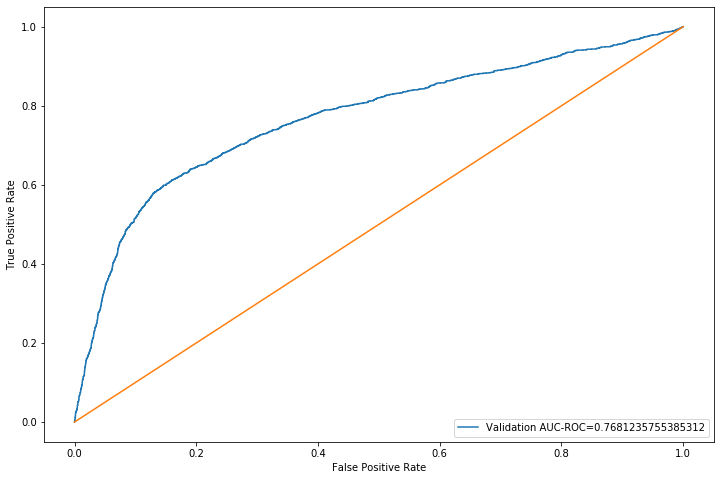

In [20]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(ytest,pred) 
auc = roc_auc_score(ytest, pred) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc)) 
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

In [21]:
# Confusion Matrix
pred_val = model.predict(xtest)

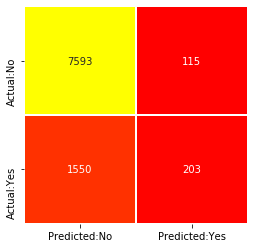

In [31]:
label_preds = pred_val

cm = confusion_matrix(ytest,label_preds)

def plot_confusion_matrix(cm, label,normalized=True, cmap='autumn'):
    plt.figure(figsize=[4,4])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm, annot=cm, fmt='g', xticklabels=[f'Predicted:{i}' for i in label], yticklabels=[f'Actual:{i}' for i in label],cbar=False,linewidths=0.5,cmap=cmap)
# cbar=False is used to remove the ph line from the heatmap
plot_confusion_matrix(cm, ['No', 'Yes'])

In [23]:
from sklearn.metrics import f1_score
# Recall Score
recall_score(ytest,pred_val),f1_score(ytest,pred_val)

(0.11580148317170565, 0.19604056011588605)

### Cross validation


Cross Validation is one of the most important concepts in any type of data modelling. It simply says, try to leave a sample on which you do not train the model and test the model on this sample before finalizing the model.

We divide the entire population into k equal samples. Now we train models on k-1 samples and validate on 1 sample. Then, at the second iteration we train the model with a different sample held as validation. 

In k iterations, we have basically built model on each sample and held each of them as validation. This is a way to reduce the selection bias and reduce the variance in prediction power.

Since it builds several models on different subsets of the dataset, we can be more sure of our model performance if we use CV for testing our models.

In [24]:
index=[f'{i} fold' for i in range(1,6)]
index.append('Mean')
class_report=pd.DataFrame(columns=['ROC AUC Score','Recall Score','Precision Score','F1 score'],index=index)
def cv_score(ml_model, rstate = 12, thres = 0.5, cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    roc_list=[]
    recall_list=[]
    precision_list=[]
    f1_list=[]
    
    
    # 5 Fold cross validation stratified on the basis of target
    kf = StratifiedKFold(n_splits=5,random_state=rstate,shuffle=True)
    for df_index,test_index in kf.split(df1,y_all):
        train_features,val_features = df1.loc[df_index],df1.loc[test_index]
        train_target,val_target = y_all.loc[df_index],y_all.loc[test_index]
            
        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(train_features, train_target)
        pred_probs = model.predict_proba(val_features)
        pp = []
         
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j>thres:
                pp.append(1)
            else:
                pp.append(0)
         
        # Calculate scores for each fold and print
        pred_val = pp
        roc_score = roc_auc_score(val_target,pred_probs[:,1])
        recall = recall_score(val_target,pred_val)
        precision = precision_score(val_target,pred_val)
        f1=f1_score(val_target,pred_val)
        
        roc_list.append(roc_score)
        recall_list.append(recall)
        precision_list.append(precision)
        f1_list.append(f1)
        
         # Save scores
        cv_scores.append(roc_score)
        i+=1
        
        
    roc_list.append(np.mean(roc_list))
    recall_list.append(np.mean(recall_list))
    precision_list.append(np.mean(precision_list))
    f1_list.append(np.mean(f1_list))
    
    class_report['ROC AUC Score']=roc_list
    class_report['Recall Score']=recall_list
    class_report['Precision Score']=precision_list
    class_report['F1 score']=f1_list
    display(class_report)
    
    return cv_scores

In [25]:
baseline_scores = cv_score(LogisticRegression(), cols = baseline_cols)

,ROC AUC Score,Recall Score,Precision Score,F1 score
1 fold,0.764484,0.075095,0.576642,0.132885
2 fold,0.778537,0.076996,0.653226,0.137755
3 fold,0.755260,0.134981,0.642534,0.223095
4 fold,0.758210,0.116920,0.650794,0.198227
5 fold,0.765319,0.113118,0.563981,0.188440
Mean,0.764362,0.103422,0.617435,0.176080


Now let us try using all columns available to check if we get significant improvement.

In [26]:
all_feat_scores = cv_score(LogisticRegression())

,ROC AUC Score,Recall Score,Precision Score,F1 score
1 fold,0.732937,0.109316,0.506608,0.179828
2 fold,0.768016,0.196768,0.680921,0.305310
3 fold,0.739313,0.168251,0.572816,0.260103
4 fold,0.732845,0.120722,0.601896,0.201108
5 fold,0.758856,0.173004,0.598684,0.268437
Mean,0.746393,0.153612,0.592185,0.242957


There is some improvement in both ROC AUC Scores and Precision/Recall Scores.

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
rf_all_features = cv_score(RandomForestClassifier(n_estimators=100, max_depth=8))

,ROC AUC Score,Recall Score,Precision Score,F1 score
1 fold,0.819733,0.354563,0.732809,0.477899
2 fold,0.844743,0.365019,0.771084,0.495484
3 fold,0.837157,0.350760,0.753061,0.478599
4 fold,0.828657,0.354563,0.738614,0.479127
5 fold,0.822023,0.353612,0.735178,0.477535
Mean,0.830462,0.355703,0.746149,0.481729


## Comparison of Different model fold wise

Let us visualise the cross validation scores for each fold for the following 3 models and observe differences:
* Baseline Model
* Model based on all features
* Model based on top 10 features obtained from RFE

In [29]:
results_df = pd.DataFrame({'baseline':baseline_scores, 'all_feats': all_feat_scores, 'random_forest': rf_all_features})

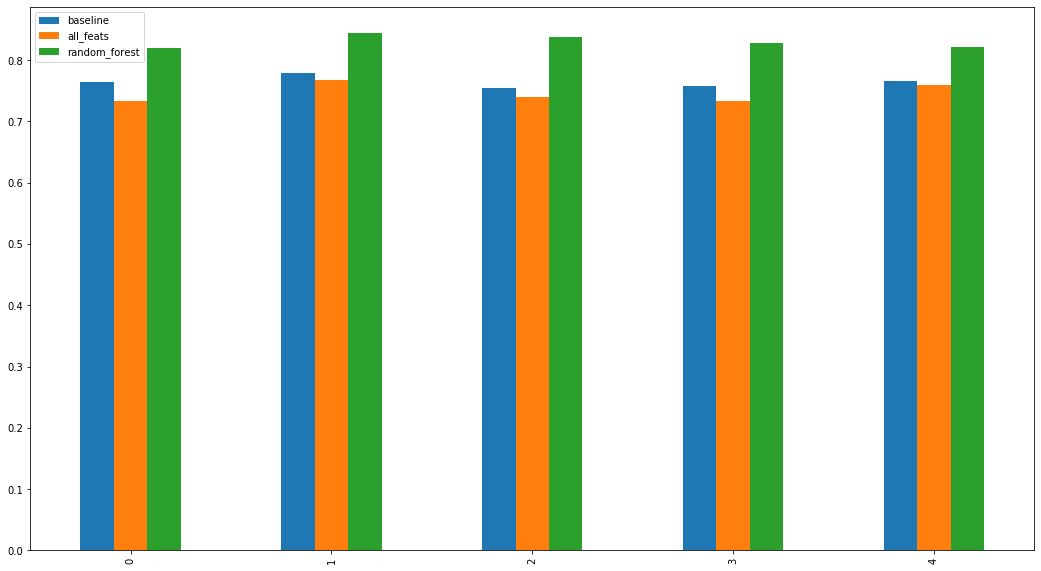

In [30]:
results_df.plot(y=["baseline", "all_feats", "random_forest"], figsize=(18,10),kind="bar")

Here, we can see that the random forest model is giving the best result for each fold and students are encouraged to try and fine tune the model to get the best results.